In [3]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import re
from zipfile import ZipFile
from collections import Counter
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
from nltk.corpus import wordnet as wn
import re
InteractiveShell.ast_node_interactivity = "all"

## TODO:

* Implement counting human vs non human objects of human subjects
* Implement counting human vs non human subjects of human objects
* Create outputs that are filtered by verbs
* Look for emotion lists, maybe also body language markers
* Look at scene descriptions for interesting words


**People-centric selections – suggested criteria:**

* person
* actions
* objects

    d.      facial expressions  
    e.      body language  
    f.       location/temporal  
    g.      mood   
    h.      camera shots  


In [24]:
def load_json(json_file):
    d = None

    with open(json_file) as f:
        d = json.load(f)
    
    return d


def load_json_from_zip(zip_file):
    d = None
    with ZipFile(zip_file) as z:
        with z.open(z.namelist()[0]) as file:
            d = json.load(file)
    return d



In [ ]:
attributes_json = '../../download/1.2/VG/1.2/attributes.json'
#relationships_data = load_json_from_zip(relationships_zip)
attributes_data = load_json(attributes_json)
attributes_data[0]

In [25]:
relationships_json = '../../download/1.2/VG/1.2/relationships.json'
#relationships_data = load_json_from_zip(relationships_zip)
relationships_data = load_json(relationships_json)
relationships_data[0]

{'relationships': [{'predicate': 'ON',
   'object': {'name': 'street',
    'h': 262,
    'object_id': 5046,
    'synsets': ['street.n.01'],
    'w': 714,
    'y': 328,
    'x': 77},
   'relationship_id': 15927,
   'synsets': ['along.r.01'],
   'subject': {'name': 'shade',
    'h': 192,
    'object_id': 5045,
    'synsets': ['shade.n.01'],
    'w': 274,
    'y': 338,
    'x': 119}},
  {'predicate': 'wears',
   'object': {'name': 'sneakers',
    'h': 26,
    'object_id': 5048,
    'synsets': ['gym_shoe.n.01'],
    'w': 52,
    'y': 489,
    'x': 243},
   'relationship_id': 15928,
   'synsets': ['wear.v.01'],
   'subject': {'name': 'man',
    'h': 262,
    'object_id': 1058529,
    'synsets': ['man.n.01'],
    'w': 60,
    'y': 249,
    'x': 238}},
  {'predicate': 'has',
   'object': {'name': 'headlight',
    'h': 15,
    'object_id': 5050,
    'synsets': ['headlight.n.01'],
    'w': 23,
    'y': 366,
    'x': 514},
   'relationship_id': 15929,
   'synsets': ['have.v.01'],
   'subject': {

In [32]:
region_descr_json = '../../download/1.2/VG/1.2/region_descriptions.json'
region_descr_data = load_json(region_descr_json)
region_descr_data[0]

{'regions': [{'region_id': 1382,
   'width': 82,
   'height': 139,
   'image_id': 1,
   'phrase': 'the clock is green in colour',
   'y': 57,
   'x': 421},
  {'region_id': 1383,
   'width': 182,
   'height': 109,
   'image_id': 1,
   'phrase': 'shade is along the street ',
   'y': 372,
   'x': 194},
  {'region_id': 1384,
   'width': 61,
   'height': 30,
   'image_id': 1,
   'phrase': 'man is wearing sneakers',
   'y': 491,
   'x': 241},
  {'region_id': 1385,
   'width': 36,
   'height': 36,
   'image_id': 1,
   'phrase': 'cars headlights are off',
   'y': 377,
   'x': 617},
  {'region_id': 1386,
   'width': 41,
   'height': 49,
   'image_id': 1,
   'phrase': 'bikes are parked at the far edge',
   'y': 298,
   'x': 322},
  {'region_id': 1432,
   'width': 84,
   'height': 178,
   'image_id': 1,
   'phrase': 'A sign on the facade of the building',
   'y': 14,
   'x': 122},
  {'region_id': 1433,
   'width': 96,
   'height': 332,
   'image_id': 1,
   'phrase': 'A tree trunk on the sidewalk'

In [24]:
len(attributes_data)
attributes_data[0]

108077

{'image_id': 1,
 'attributes': [{'synsets': ['clock.n.01'],
   'h': 339,
   'object_id': 1058498,
   'names': ['clock'],
   'w': 79,
   'attributes': ['green', 'tall'],
   'y': 91,
   'x': 421},
  {'synsets': ['street.n.01'],
   'h': 262,
   'object_id': 5046,
   'names': ['street'],
   'w': 714,
   'attributes': ['sidewalk'],
   'y': 328,
   'x': 77},
  {'synsets': ['shade.n.01'],
   'h': 192,
   'object_id': 5045,
   'names': ['shade'],
   'w': 274,
   'y': 338,
   'x': 119},
  {'synsets': ['man.n.01'],
   'h': 262,
   'object_id': 1058529,
   'names': ['man'],
   'w': 60,
   'y': 249,
   'x': 238},
  {'synsets': ['gym_shoe.n.01'],
   'h': 26,
   'object_id': 5048,
   'names': ['sneakers'],
   'w': 52,
   'attributes': ['grey'],
   'y': 489,
   'x': 243},
  {'synsets': ['headlight.n.01'],
   'h': 15,
   'object_id': 5050,
   'names': ['headlight'],
   'w': 23,
   'attributes': ['off'],
   'y': 366,
   'x': 514},
  {'synsets': ['car.n.01'],
   'h': 98,
   'object_id': 5049,
   'names'

In [79]:
def count_attributes_per_synset(query_synset):
    word_cnt = Counter() # count individual attribute values
    attr_shared_cnt = Counter() # count full phrases
    attr_cnt = Counter() # count total number of attributes per query_word
    query_cnt = 0 # count number of query

    for i, row in enumerate(attributes_data):
        for attr in row['attributes']:
            for syn in attr['synsets']:
                # query_word detected
                if syn == query_synset or query_synset == '*':
                    query_cnt += 1
                    if 'attributes' in attr.keys():
                        attrs = attr['attributes']
                        attr_cnt[str(len(attrs))] += 1
                        attr_shared_cnt[str(sorted(attrs))] += 1
                        for attr in attrs:
                            word_cnt[attr.strip()] += 1
                    else:
                        attrs = 'no attributes'
                        attr_cnt[str(0)] += 1
                    break

                    #print(f"Entry {i} contains match '{s}' with attributes {attrs}")
    print(f"Done. {len(attributes_data)} rows processed, {query_cnt} intances of '{query_synset}' found")
    
    return word_cnt, attr_shared_cnt, attr_cnt, query_cnt


def plot_bar_counts(counter, maxnum = 20, title = None, filename = None):
    if not len(counter):
        print("Empty counter")
        return
    # sort the counter by values
    sorted_counter = counter.most_common(maxnum)
    
    x = np.array(sorted_counter)[:,0][::-1]
    y = np.uint32(np.array(sorted_counter)[:,1])[::-1]
    
    plt.figure(figsize=(10,20))
    if title:
        plt.title(title, fontsize = 15)
        
    for i, v in enumerate(y):
        plt.text(25, i-.15, str(v), color='black', fontweight='bold', fontsize=15)

    plt.yticks(fontsize = 20)
    plt.barh(x, y)
    
    if filename:
        plt.savefig('plots/' + filename + '.png', bbox_inches = 'tight')
    plt.show()
    
    
def store_count_to_csv(counter, filename):
    pass

def sort_counter(counter):
    sorted_counter = sorted(((value, key) for (key,value) in counter.items()))
    return sorted_counter

# Print a list with humans sorted by frequency with attached definition - check WP 02 for template


In [70]:
#synset = 'man.n.01'
synset = 'person.n.01'
word_cnt, attr_shared_cnt, attr_cnt, query_cnt = count_attributes_per_synset(synset) 

Done. 108077 rows processed, 57415 intances of 'person.n.01' found


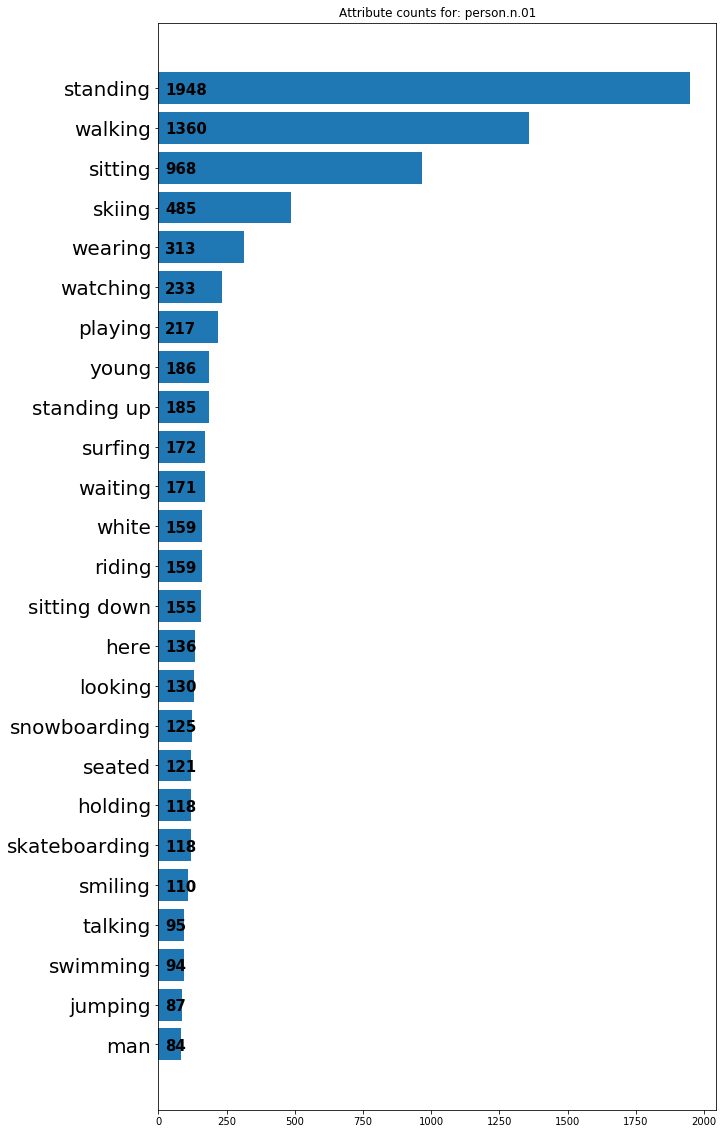

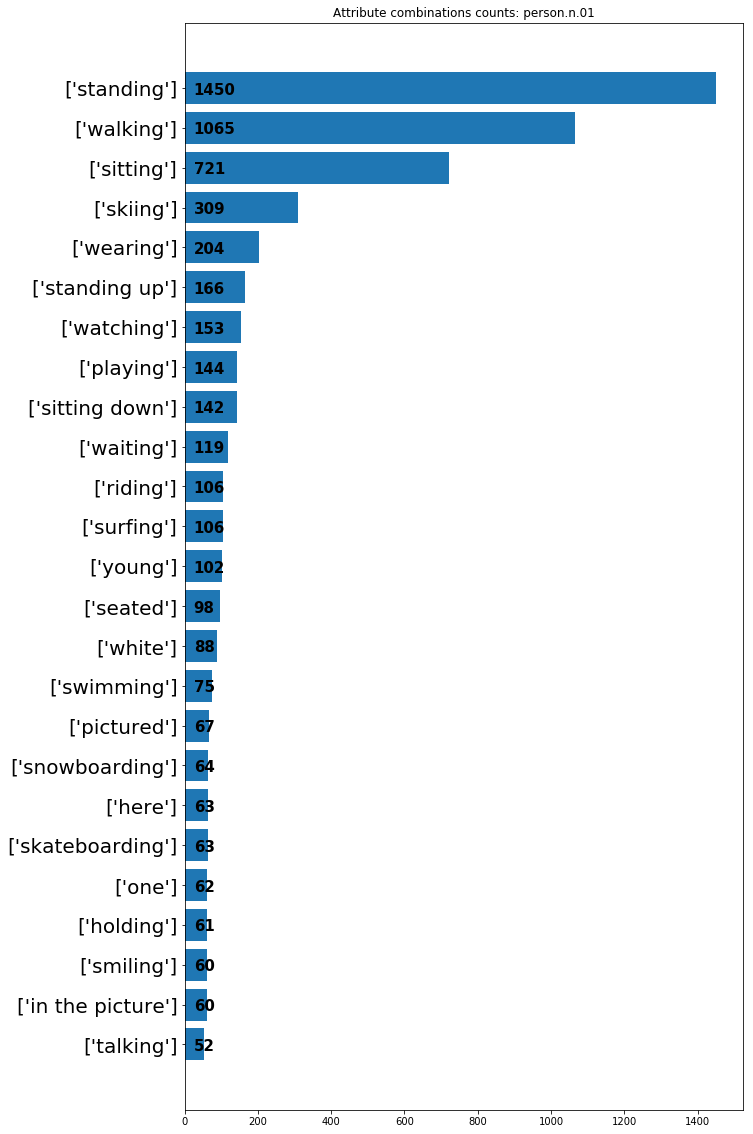

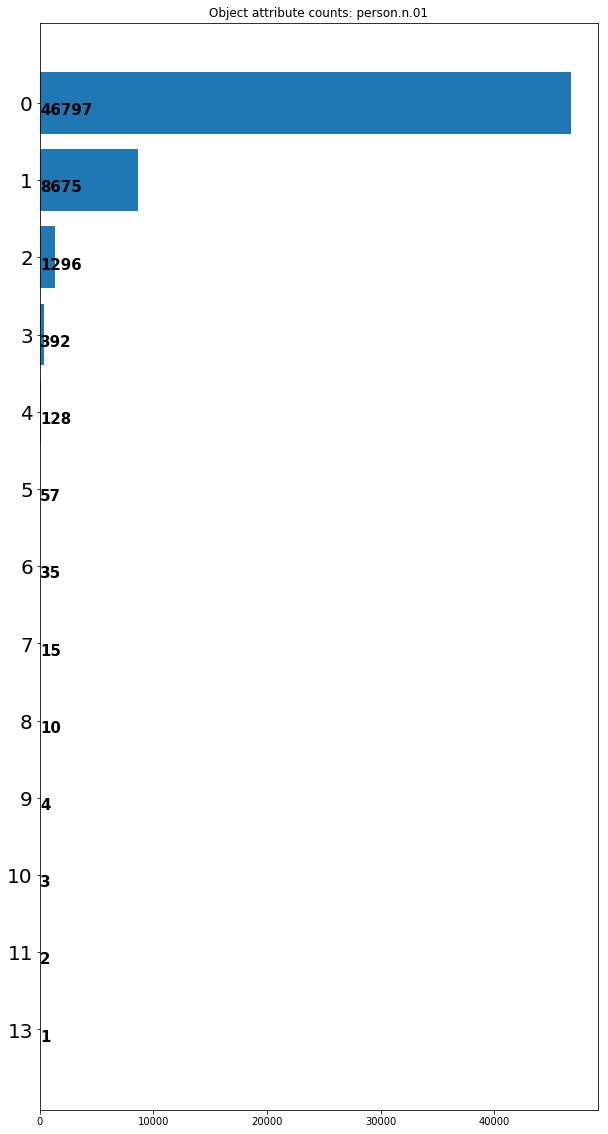

In [78]:
plot_bar_counts(word_cnt, 25, f"Attribute counts for: {synset}", 'attr_count_' + synset)
plot_bar_counts(attr_shared_cnt, 25, f"Attribute combinations counts: {synset}", 'attr_combi_count_' + synset) 
plot_bar_counts(attr_cnt, 25, f"Object attribute counts: {synset}", 'attr_numbers_' + synset ) 

In [103]:
def get_hyponyms(root):
    term_list = []
    for s in root.hyponyms():
        term_list += [s.name()]
        h = get_hyponyms(s)
        if len(h):
            term_list += h
        
    return term_list


def is_human(synset_name):
    if synset_name in human_synsets:
        return True
    elif wn.synset(synset_name).lemmas()[0].synset().name() in human_synsets:
        return True
    else:
        return False

def is_verb(syn_name):
    re_verb = '\.v\.'
    
    if re.search(re_verb, syn_name):
        return True
    else:
        return False
    
def count_synsets(data, synset_names):
    synset_cnt = Counter() # count individual synsets
    name_cnt = Counter() # count names associated with synsets
    matches = 0 # count number of matching synsets
    rows = 0 # count number of rows that had matching synsets

    for i, row in enumerate(data):
        row_matched = False
        for attr in row['attributes']:
            for syn_name in attr['synsets']:
                if is_human(syn_name):
                    synset_cnt[syn_name] += 1
                    matches += 1
                    row_matched = True
                    
                    for name in attr['names']:
                        name_cnt[name] += 1
                        
        if row_matched:
            rows += 1

    print(f"Done. {len(data)} rows processed, {matches} instances of found in {rows} rows")
    
    return synset_cnt, name_cnt, matches, rows


def store_raw_counts(counter, countername, filename, desc = None):
    """
    counter - counter object (may be unsorted)
    filename - partial filename of the form "type/name", base dir and extension added 
        automatically by this function
    countername - name of the column with labels of the counts (e.g 'synset' or 'name')
    desc - optional description that is added as a comment on the first line of the CSV
    """
    base_dir = 'raw_counts/'
    sorted_counter = counter.most_common()
    col_names = [countername,'count']
    df = pd.DataFrame(sorted_counter, columns = col_names)
    df = df[df['count'] >= 100]

    filename = base_dir + filename + '.csv'

    with open(filename, 'w') as f:
        if desc:
            f.write('#' + desc + '\n')

        df.to_csv(f, index = False)


def count_relationships(data, synset_names, mode = 1, verbs = False):
    """
    TODO:
    Count relationships of the synset_names in data based on mode
    1 = count only the relationships where subjects  match synset_names
    2 = count only the relationships where objects match synset_names
    3 = count the cases where either subjects or objects match synset_names
    4 = count the cases where both subjects and objects match synset names
    
    verbs: when True, only count relations where relation is a verb
    Implement this first:
    """
    # TODO:
    # Handle person as a subject, person as an object or both
    rel_name_cnt = Counter() # count relation names where human is a subject
    rel_syn_cnt = Counter() # count relation synsets where human is a subject
    
    subj_name_cnt = Counter() # count subject names where human is a subject
    subj_syn_cnt = Counter() # count subject synsets where human is a subject
    
    obj_name_cnt = Counter() # count object names where human is a subject
    obj_syn_cnt = Counter() # count object synsets where human is a subject
    
    matches = 0 # count the number of matching relations
    rows = 0 # count the number of matching images (data rows in json)
    
    for i, row in enumerate(data):
        row_matched = False
        for rel in row['relationships']:
            # skip if non-verb when verbs = True
            subject_added = False
            for s_syn in rel['subject']['synsets']:
                if is_human(s_syn):
                    subj_syn_cnt[s_syn] += 1
                    # count all objects and relationship only once   
                    if not subject_added: 
                        # Count subject name:
                        subj_name_cnt[rel['subject']['name']] += 1
                        
                        # Count relationships
                        rel_name_cnt[rel['predicate']] += 1
                        for r_syn in rel['synsets']:
                            rel_syn_cnt[r_syn] += 1
                        
                        # Count objects
                        obj_name_cnt[rel['object']['name']] += 1      
                        for o_syn in rel['object']['synsets']:
                            obj_syn_cnt[o_syn] += 1
                            
                        matches += 1
                        subject_added = True
                        row_matched = True
                        
        if row_matched:
            rows += 1
    
    print(f"Done. {len(data)} rows processed, {matches} instances of found in {rows} rows")
    return rel_name_cnt.max, rel_syn_cnt, subj_name_cnt, subj_syn_cnt, obj_name_cnt, obj_syn_cnt

def plot_and_output_csv(counter, countername, maxnum, title, filename):
    plot_bar_counts(counter, maxnum, title, filename) 
    store_raw_counts(counter, countername, filename, title)

In [29]:
# print synsets lists that have more than one element
data = relationships_data 
rel_count = 0
obj_count = 0
subj_count = 0
for i, row in enumerate(data):
    for j, rel in enumerate(row['relationships']):
        if len(rel['synsets']) > 1:
            rel_count += 1
            print(f"{i},{j}: {len(rel['synsets'])} relation synsets - {rel['synsets']}")
        if len(rel['object']['synsets']) > 1:
            obj_count += 1
            print(f"{i},{j}: {len(rel['object']['synsets'])} object synsets - {rel['object']['synsets']}")
        if len(rel['subject']['synsets']) > 1:
            subj_count += 1
            print(f"{i},{j}: {len(rel['subject']['synsets'])} subject synsets - {rel['subject']['synsets']}")

print(f"{rel_count} multi-synset relations found")
print(f"{obj_count} multi-synset objects found")
print(f"{subj_count} multi-synset subjects found")
    

14,2: 2 object synsets - ['paper.n.01', 'spot.n.10']
14,2: 2 subject synsets - ['corner.n.01', 'paper.n.01']
14,3: 2 object synsets - ['paper.n.01', 'puzzle.n.01']
14,3: 2 subject synsets - ['paper.n.01', 'puzzle.n.01']
14,6: 2 subject synsets - ['button.n.01', 'round.n.01']
15,2: 2 object synsets - ['tree.n.01', 'wayside.n.01']
15,3: 2 object synsets - ['man.n.01', 'spectacles.n.01']
15,3: 2 subject synsets - ['man.n.01', 'spectacles.n.01']
15,6: 2 object synsets - ['pole.n.01', 'sign.n.02']
15,6: 2 subject synsets - ['pole.n.01', 'sign.n.02']
15,7: 2 subject synsets - ['crack.n.01', 'road.n.01']
15,8: 2 object synsets - ['arrow.n.01', 'sidewalk.n.01']
15,8: 2 subject synsets - ['arrow.n.01', 'sidewalk.n.01']
15,9: 2 subject synsets - ['bag.n.01', 'man.n.01']
15,10: 2 object synsets - ['car.n.01', 'curb.n.01']
15,11: 2 subject synsets - ['cone.n.01', 'road.n.01']
15,12: 2 object synsets - ['man.n.01', 'spectacles.n.01']
15,12: 2 subject synsets - ['man.n.01', 'spectacles.n.01']
16,1: 

10469,12: 2 subject synsets - ['bay.n.01', 'boat.n.01']
10469,13: 2 subject synsets - ['bay.n.01', 'boat.n.01']
10469,14: 2 object synsets - ['sky.n.01', 'tree.n.01']
10469,15: 2 object synsets - ['mast.n.01', 'sail.n.01']
10469,15: 2 subject synsets - ['boat.n.01', 'mast.n.01']
10480,14: 2 object synsets - ['mound.n.01', 'pitcher.n.01']
10480,15: 2 object synsets - ['batter.n.01', 'box.n.01']
10516,1: 2 subject synsets - ['backpack.n.01', 'man.n.01']
10516,2: 2 object synsets - ['land.n.04', 'pole.n.01']
10516,2: 2 subject synsets - ['land.n.04', 'pole.n.01']
10516,3: 2 object synsets - ['ski.n.01', 'snow.n.01']
10516,3: 2 subject synsets - ['ski.n.01', 'snow.n.01']
10516,5: 2 object synsets - ['pole.n.01', 'snow.n.01']
10516,10: 2 subject synsets - ['man.n.01', 'sweater.n.01']
10516,12: 2 object synsets - ['bag.n.01', 'guy.n.01']
10516,12: 2 subject synsets - ['bag.n.01', 'guy.n.01']
10516,13: 2 object synsets - ['guy.n.01', 'ski.n.01']
10516,13: 2 subject synsets - ['guy.n.01', 'ski

14972,20: 2 object synsets - ['dust.n.01', 'soil.n.02']
14978,6: 2 object synsets - ['helmet.n.02', 'spectacles.n.01']
14978,21: 2 object synsets - ['man.n.01', 'woman.n.01']
14980,31: 2 object synsets - ['edge.n.01', 'outfield.n.01']
15004,9: 2 subject synsets - ['food.n.01', 'plate.n.04']
15023,12: 2 subject synsets - ['brush.n.01', 'tree.n.01']
15030,9: 2 object synsets - ['edge.n.01', 'plate.n.04']
15030,16: 2 subject synsets - ['fruit.n.01', 'ring.n.02']
15030,17: 2 subject synsets - ['fruit.n.01', 'ring.n.02']
15030,19: 2 subject synsets - ['glass.n.01', 'water.n.01']
15030,20: 2 subject synsets - ['glass.n.01', 'water.n.01']
15030,23: 2 object synsets - ['glass.n.01', 'water.n.01']
15030,24: 2 subject synsets - ['glass.n.01', 'liquid.n.01']
15030,29: 2 subject synsets - ['edge.n.01', 'plate.n.04']
15030,30: 2 subject synsets - ['fork.n.01', 'tip.n.01']
15030,31: 2 subject synsets - ['part.n.01', 'ring.n.02']
15030,32: 2 subject synsets - ['part.n.01', 'part.n.01']
15031,0: 2 sub

20343,8: 2 subject synsets - ['bottle.n.01', 'honey.n.01']
20349,20: 2 subject synsets - ['shirt.n.01', 'woman.n.01']
20349,21: 2 subject synsets - ['shirt.n.01', 'woman.n.01']
20349,30: 2 subject synsets - ['beer.n.01', 'bottle.n.01']
20349,33: 2 subject synsets - ['pitcher.n.01', 'water.n.01']
20381,5: 2 subject synsets - ['baby.n.01', 'saunterer.n.01']
20381,7: 2 subject synsets - ['engine.n.01', 'plaything.n.01']
20381,12: 2 subject synsets - ['cone.n.01', 'fire_engine.n.01']
20442,2: 2 object synsets - ['head.n.01', 'neck.n.01']
20483,24: 2 object synsets - ['chef.n.01', 'uniform.n.01']
20493,22: 2 object synsets - ['axial_rotation.n.01', 'towel.n.01']
20494,11: 2 object synsets - ['picture.n.01', 'side.n.01']
20536,3: 2 object synsets - ['bathroom.n.01', 'man.n.01']
20536,8: 2 object synsets - ['bathroom.n.01', 'man.n.01']
20536,12: 2 object synsets - ['bathroom.n.01', 'man.n.01']
20536,14: 2 object synsets - ['bathroom.n.01', 'man.n.01']
20536,15: 2 object synsets - ['bathroom.n

29258,4: 2 object synsets - ['gram.n.01', 'second.n.01']
29263,16: 2 subject synsets - ['man.n.01', 'neck.n.01']
29291,10: 2 object synsets - ['lady.n.01', 'neck.n.01']
29314,13: 2 subject synsets - ['head.n.01', 'horse.n.01']
29314,14: 2 object synsets - ['head.n.01', 'horse.n.01']
29314,15: 2 object synsets - ['mouth.n.01', 'nose.n.01']
29314,20: 2 object synsets - ['horse.n.01', 'rider.n.01']
29318,6: 2 subject synsets - ['driver.n.01', 'seat.n.01']
29320,3: 2 object synsets - ['nose.n.01', 'nostril.n.01']
29338,2: 2 object synsets - ['head.n.01', 'woman.n.01']
29367,0: 2 object synsets - ['side.n.01', 'side.n.01']
29377,1: 2 subject synsets - ['cat.n.01', 'shadow.n.01']
29383,0: 2 object synsets - ['grain.n.02', 'milk.n.01']
29425,35: 2 object synsets - ['man.n.01', 'shirt.n.01']
29427,10: 2 subject synsets - ['batter.n.01', 'circle.n.01']
29427,29: 2 subject synsets - ['batter.n.01', 'box.n.01']
29427,31: 2 subject synsets - ['batter.n.01', 'circle.n.01']
29443,0: 2 object synsets

40494,0: 2 subject synsets - ['fiber.n.01', 'lamp.n.01']
40494,1: 2 subject synsets - ['book.n.01', 'table.n.02']
40499,39: 2 subject synsets - ['bottle.n.01', 'group.n.01']
40514,19: 2 subject synsets - ['meat.n.01', 'pizza.n.01']
40514,20: 2 object synsets - ['meat.n.01', 'piece.n.01']
40657,5: 2 subject synsets - ['glass.n.01', 'water.n.01']
40657,14: 2 subject synsets - ['glass.n.01', 'water.n.01']
40681,1: 2 subject synsets - ['cheese.n.01', 'chili.n.01']
40681,8: 2 subject synsets - ['cheese.n.01', 'chili.n.01']
40683,0: 2 subject synsets - ['man.n.01', 'street.n.01']
40683,2: 2 object synsets - ['helmet.n.02', 'man.n.01']
40683,3: 2 subject synsets - ['helmet.n.02', 'man.n.01']
40683,4: 2 object synsets - ['elbow_pad.n.01', 'man.n.01']
40683,4: 2 subject synsets - ['elbow_pad.n.01', 'man.n.01']
40683,16: 2 object synsets - ['glove.n.02', 'man.n.01']
40683,16: 2 subject synsets - ['glove.n.02', 'man.n.01']
40683,17: 2 object synsets - ['glove.n.02', 'man.n.01']
40683,17: 2 subjec

50568,12: 2 subject synsets - ['cheese.n.01', 'macaroni.n.01']
50595,3: 2 subject synsets - ['driver.n.01', 'side.n.01']
50604,11: 2 object synsets - ['animal.n.01', 'head.n.01']
50641,3: 2 subject synsets - ['bear.n.01', 'shadow.n.01']
50679,29: 2 object synsets - ['head.n.01', 'person.n.01']
50720,12: 2 object synsets - ['baby.n.01', 'mouth.n.01']
50762,6: 2 subject synsets - ['light.n.01', 'spot.n.05']
50762,7: 2 subject synsets - ['light.n.01', 'spot.n.05']
50762,10: 2 subject synsets - ['grass.n.01', 'spot.n.05']
50762,11: 2 subject synsets - ['grass.n.01', 'spot.n.05']
50762,15: 2 subject synsets - ['pair.n.01', 'zebra.n.01']
50762,16: 2 subject synsets - ['pair.n.01', 'zebra.n.01']
50789,16: 2 object synsets - ['giraffe.n.01', 'neck.n.01']
50800,15: 2 object synsets - ['face.n.01', 'man.n.01']
50839,10: 2 object synsets - ['batter.n.01', 'helmet.n.02']
50853,16: 2 subject synsets - ['drop.n.01', 'water.n.01']
50860,14: 2 object synsets - ['enclosure.n.01', 'giraffe.n.01']
50867,

60826,1: 2 object synsets - ['hand.n.01', 'lady.n.01']
60863,1: 2 subject synsets - ['hand.n.01', 'woman.n.01']
60863,6: 2 subject synsets - ['horse.n.01', 'rib.n.01']
60977,20: 2 object synsets - ['game.n.01', 'hoop.n.01']
61016,18: 2 object synsets - ['girl.n.01', 'hair.n.01']
61055,2: 2 object synsets - ['head.n.01', 'man.n.01']
61077,18: 2 object synsets - ['head.n.01', 'man.n.01']
61087,16: 2 subject synsets - ['chair.n.01', 'pair.n.01']
61087,17: 2 subject synsets - ['chair.n.01', 'pair.n.01']
61087,20: 2 subject synsets - ['chair.n.01', 'pair.n.01']
61111,15: 2 object synsets - ['head.n.01', 'player.n.01']
61124,5: 2 subject synsets - ['background.n.02', 'people.n.01']
61141,24: 2 subject synsets - ['dog.n.01', 'eye.n.01']
61174,5: 2 object synsets - ['batter.n.01', 'hand.n.01']
61174,6: 2 object synsets - ['batter.n.01', 'hand.n.01']
61208,20: 2 object synsets - ['flower.n.01', 'ivy.n.01']
61208,29: 2 object synsets - ['flower.n.01', 'ivy.n.01']
61208,35: 2 object synsets - ['f

68945,2: 2 object synsets - ['man.n.01', 'shirt.n.01']
68947,7: 2 object synsets - ['head.n.01', 'man.n.01']
68963,17: 2 subject synsets - ['hand.n.01', 'man.n.01']
68989,2: 2 object synsets - ['head.n.01', 'woman.n.01']
68989,6: 2 object synsets - ['hand.n.01', 'woman.n.01']
69003,20: 2 object synsets - ['head.n.01', 'man.n.01']
69036,2: 2 object synsets - ['head.n.01', 'man.n.01']
69052,26: 2 object synsets - ['dog.n.01', 'vest.n.01']
69068,8: 2 object synsets - ['arm.n.01', 'skier.n.01']
69071,6: 2 object synsets - ['corner.n.01', 'glass.n.01']
69071,7: 2 object synsets - ['glass.n.01', 'water.n.01']
69071,8: 2 object synsets - ['corner.n.01', 'glass.n.01']
69071,14: 2 subject synsets - ['pizza.n.01', 'spinach.n.01']
69071,17: 2 object synsets - ['crust.n.02', 'pizza.n.01']
69086,10: 2 object synsets - ['back.n.01', 'man.n.01']
69093,0: 2 subject synsets - ['group.n.01', 'people.n.01']
69093,3: 2 subject synsets - ['group.n.01', 'people.n.01']
69093,6: 2 object synsets - ['point.n.0

78216,0: 2 object synsets - ['face.n.01', 'man.n.01']
78216,1: 2 object synsets - ['man.n.01', 'neck.n.01']
78216,2: 2 object synsets - ['man.n.01', 'neck.n.01']
78277,3: 2 object synsets - ['foot.n.01', 'man.n.01']
78299,1: 2 subject synsets - ['catcher.n.01', 'hand.n.01']
78299,13: 2 subject synsets - ['batter.n.01', 'box.n.01']
78344,3: 2 subject synsets - ['park.n.01', 'word.n.01']
78376,8: 2 object synsets - ['giraffe.n.01', 'neck.n.01']
78385,17: 2 object synsets - ['boat.n.01', 'roof.n.01']
78457,18: 2 object synsets - ['cow.n.01', 'ear.n.01']
78458,26: 2 object synsets - ['foot.n.01', 'man.n.01']
78507,23: 2 object synsets - ['edge.n.01', 'water.n.01']
78558,8: 2 object synsets - ['back.n.01', 'cat.n.01']
78566,17: 2 object synsets - ['hand.n.01', 'woman.n.01']
78574,4: 2 object synsets - ['computer.n.01', 'room.n.01']
78624,1: 2 subject synsets - ['facade.n.01', 'house.n.01']
78631,4: 2 subject synsets - ['face.n.01', 'woman.n.01']
78716,14: 2 subject synsets - ['child.n.01', 

93490,27: 2 object synsets - ['back.n.01', 'bus.n.01']
93492,20: 2 object synsets - ['doll.n.01', 'head.n.01']
93518,13: 2 object synsets - ['lap.n.01', 'woman.n.01']
93566,2: 2 object synsets - ['container.n.01', 'lock.n.01']
93571,1: 2 subject synsets - ['button.n.01', 'row.n.01']
93571,7: 2 subject synsets - ['symbol.n.01', 'wireless_local_area_network.n.01']
93761,12: 2 object synsets - ['girl.n.01', 'lap.n.01']
93827,11: 2 object synsets - ['foot.n.01', 'girl.n.01']
93941,32: 2 subject synsets - ['batter.n.01', 'box.n.01']
94032,1: 2 subject synsets - ['foot.n.01', 'horse.n.01']
94032,2: 2 subject synsets - ['foot.n.01', 'horse.n.01']
94032,3: 2 subject synsets - ['foot.n.01', 'horse.n.01']
94238,19: 2 subject synsets - ['duck.n.01', 'feather.n.01']
94293,48: 2 object synsets - ['necktie.n.01', 'spectacles.n.01']
94293,49: 2 object synsets - ['man.n.01', 'spectacles.n.01']
94297,16: 2 subject synsets - ['catcher.n.01', 'helmet.n.02']
94330,1: 2 object synsets - ['bird.n.01', 'wing

104118,10: 2 object synsets - ['board.n.02', 'trail.n.01']
104118,10: 2 subject synsets - ['board.n.02', 'trail.n.01']
104118,14: 2 subject synsets - ['man.n.01', 'shirt.n.01']
104118,18: 2 object synsets - ['surfboard.n.01', 'water.n.01']
104118,20: 2 object synsets - ['board.n.02', 'contemplation.n.02']
104118,20: 2 subject synsets - ['contemplation.n.02', 'water.n.01']
104143,13: 2 object synsets - ['collar.n.01', 'male_child.n.01']
104159,1: 2 subject synsets - ['male_child.n.01', 'skateboard.n.01']
104159,2: 2 object synsets - ['male_child.n.01', 'shadow.n.01']
104159,2: 2 subject synsets - ['male_child.n.01', 'skateboard.n.01']
104159,4: 2 object synsets - ['child.n.01', 'helmet.n.02']
104159,5: 2 subject synsets - ['marker.n.02', 'pavement.n.01']
104159,8: 2 object synsets - ['male_child.n.01', 'paddy.n.01']
104159,9: 2 subject synsets - ['house.n.01', 'lawn.n.01']
104159,10: 2 subject synsets - ['fence.n.01', 'house.n.01']
104159,15: 2 subject synsets - ['board.n.02', 'shadow.n

In [ ]:
# Emotion synsets - smile - 3 ocurrances
# ['smile.n.01', 'woman.n.01']
# ['face.n.01', 'smile.n.01'] 

In [31]:
relationships_data[5680]['relationships'][2]

# Thus we get body parts! :)

{'predicate': 'holding',
 'object': {'name': "child's hand",
  'h': 42,
  'object_id': 3695167,
  'synsets': ['child.n.01', 'hand.n.01'],
  'w': 16,
  'y': 720,
  'x': 246},
 'relationship_id': 4046376,
 'synsets': ['be.v.01'],
 'subject': {'name': 'mother',
  'h': 170,
  'object_id': 1568602,
  'synsets': ['mother.n.01'],
  'w': 64,
  'y': 655,
  'x': 205}}

In [8]:
person_hyponyms = get_hyponyms(wn.synset('person.n.01'))
human_hyponyms = get_hyponyms(wn.synset('human.n.01'))
human_synsets = set(person_hyponyms + human_hyponyms + ['person.n.01', 'human.n.01'])

In [59]:
synset_cnt, name_cnt, _ , _ = count_synsets(attributes_data, human_synsets)

Done. 108077 rows processed, 269185 instances of found in 54290 rows


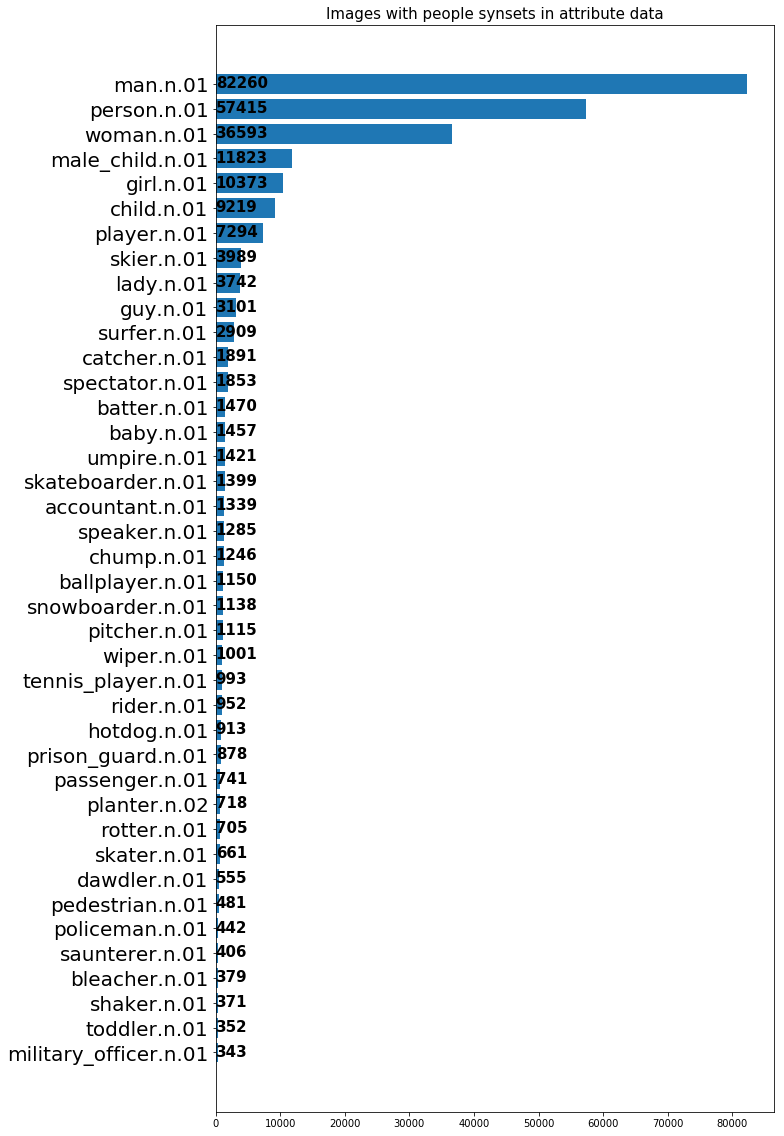

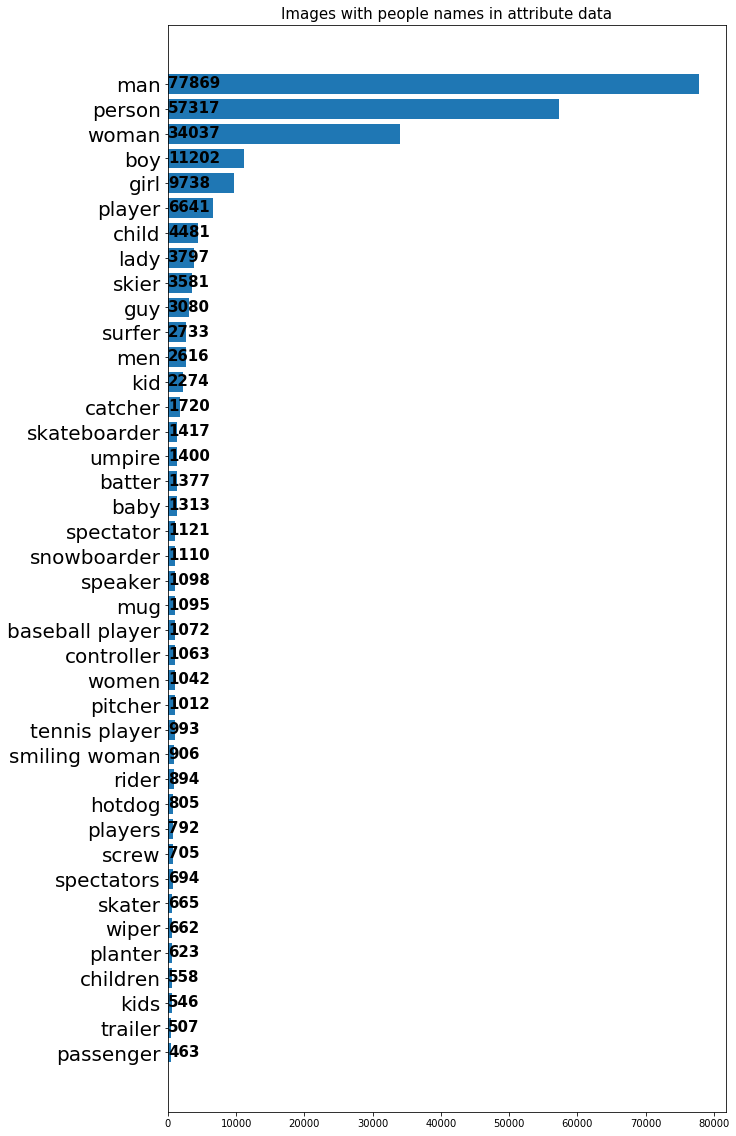

In [104]:
plot_and_output_csv(synset_cnt, 'synset', 40, f"Images with people synsets in attribute data", 'attributes/people_syns')
plot_and_output_csv(name_cnt, 'name', 40, f"Images with people names in attribute data", 'attributes/people_names' ) 



In [55]:
rel_name_cnt, rel_syn_cnt, subj_name_cnt, subj_syn_cnt, obj_name_cnt, obj_syn_cnt = count_relationships(relationships_data, human_synsets )

Done. 108077 rows processed, 419246 instances of found in 48538 rows


In [ ]:
plot_and_output_csv(rel_name_cnt, 'name', 40, f"Relation names with people as subjects", 'relationships/rel_names_subj_people' ) 
plot_and_output_csv(rel_syn_cnt, 'synset', 40, f"Relation synsets with people as subjects",  'relationships/rel_syns_subj_people' ) 

In [ ]:
plot_and_output_csv(subj_name_cnt, 'name', 40, f"Subject names with people as subjects", 'relationships/subj_names_subj_people') 
plot_and_output_csv(subj_syn_cnt, 'synset', 40, f"Subject synsets with people as subjects", 'relationships/subj_syns_subj_people') 


In [ ]:
plot_and_output_csv(obj_name_cnt, 'name', 40, f"Object names with people as subjects", 'relationships/obj_names_obj_people' ) 
plot_and_output_csv(obj_syn_cnt, 'synset', 40, f"Object synsets with people as subjects", 'relationships/obj_synsets_obj_people' )
